# Module 4 Assignment Ian Feekes
This notebook contains the work of Ian Feekes for assignent 4. If this does not meet the rubric or find the correct place, please contact me at 9163339381 ifeekes@sandiego.edu

## Summary of Findings


### Models Used

#### Model 1: Baseline

##### Model 1 Description:

This model was mirrored from the [LSTM apple stock price example](https://colab.research.google.com/drive/1BzDbcTVmF6Fm0hXjj_ulzynRsdK4Lrw1?usp=sharing#scrollTo=u4-P7JgvacAx) and is saved under models/baseline_model.h5. This model was trained from:


1.   100 Epochs for a loss of about .0015 on the final epoch
2.   50 LSTM units
3.   4 LSTM layers with dropout set to 0.2
4.   Adam optimization for gradient descent
5.   MSE loss function
Model #1: Baseline


##### Model 1 Performance

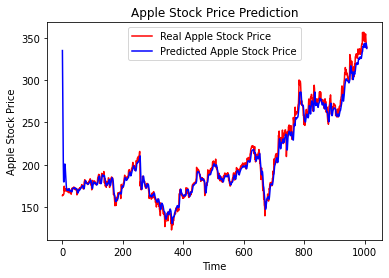



This as seen above, this model performs relatively well with predicting the trends of stock price movement, however seems to have some trouble with the local minima and maxima that the spikes produce, regularly making more modest predictions.

#### Model 2: 200 Epochs

##### Model 2 Description
This model mathces the baseline entirely but with double the epoch training, for a final loss of .001 rather than .0015 seen by the baseline.

##### Model 2 Performance


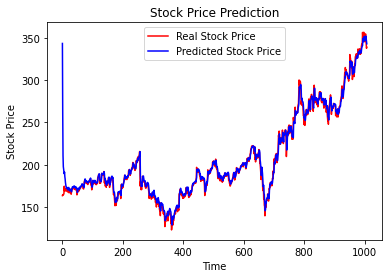

As seen above, this model is also fairly strong with predicting trends, but differs in significantly more accurately predicting the stock prices. Especially with the final peak in value, the model is much more accurately able to predict the trend.

#### Model 3: High Dropout Values 

##### Model 3 Description
This model has the same parameters as Model 2, trained at 200 epochs with a droupout value of 0.4 rather than 0.2. The loss at the final epoch was noted at .0017 which is nearly double that of the 0.2 dropout alternative Model #2. 

##### Model 3 Performance

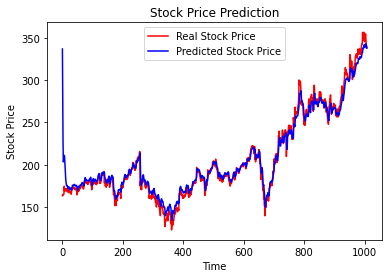

As seen from above, this model tends to have poorer performance in predicting the smaller, more subtle trends, while still following along with the higher-level trends of the actual testing data. It fails to follow the testing data values comparable with the baseline. This can be attributed to the higher dropout values resulting in missing data as a tradeoff for reduced training time.

### Model 4: Low Dropout Values

#### Model 4 Description
This model has the same parameters as Model 2, trained at 200 epochs with a dropout value of 0.1 rather than 0.2. The loss at the final epoch was noted at 0.0007, the lowest loss yet seen.

#### Model 4 Performance

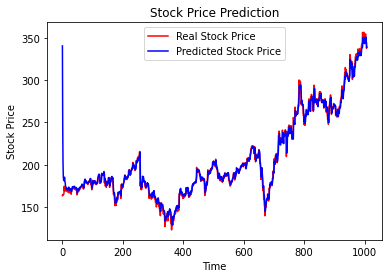

As seen above, this model has the closest predictions following the test data.

Model 5: 

## Initial Configuration
The below few cells will do some initial configuration setup - library imports, global variables, helper function definitions, drive mounting, and data imports.

### Import Libraries Used
The below cell will import the libraries we're going to use for this assignment. We are going to start off by importing the essential libraries to implement the LSTM model. We import Numpy which will allow us to contruct arrays which is the only allowed input to neural networks as opposed to DataFrames. Then matplotlib.pyplot will be imported, which will enable us to visualize the results. And pandas is imported which will enable us to import the datasets.

In [124]:
import numpy as np               
import matplotlib.pyplot as plt                  # Plotting
import pandas as pd                              # Data frame operations
from sklearn.preprocessing import MinMaxScaler   # Data scaling


from google.colab import drive                   # Used for allowing drive mounting

# Keras imports for model construction
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout


# May not need all the below libs
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque

import os
import numpy as np
import pandas as pd
import random

### Configure Drive for File Imports
The below cell mounts my google drive to allow for local file importation if this file were to be stored as a csv. In practice we may use an api or library to scrape it off the web for us to limit inconvenient file operations.

In [125]:
# Mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Declare Global Variables
The below cell declares some global variables of interest

In [126]:
seedNum = 314                                                                                       # Number denoting the seed for repeated results from random values
dataTrainFileName = '/content/drive/My Drive/Colab Notebooks/Deep_Learning/Module_4/META_train.csv' # Training file name declared for code-readability
dataTestFileNae = '/content/drive/My_Drive/Colab Notebooks/Deep_Learning/Module_4/META_test.csv'    # Testing file name declared for code-readability
numTimeSteps = 60                                                                                   # Set to 60 because example notebook did this
numEpochs = 200                                                                                     # Set to 100 because example notebook did this
#loadingModel = True                                                                                 # Whether we're loading the model or not
numUnits = 100
loadingModel = False
modelFileName = "/content/drive/My Drive/Colab Notebooks/Deep_Learning/Module_4/model_2.h5"  # Name of the model we're loading
dropoutValue = .1                                                                                  # Dropout value

### Set Random Seed
The below cell sets the seed so that we can get the same results after rerunning several times.

In [127]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(seedNum)
tf.random.set_seed(seedNum)
random.seed(seedNum)

the training dataset. In this case, we extract the "Opening" price of META stock price. By using the range from 1 to 2, only the first index is retrieved since ranges in Python, the upper bound is excluded. After execution of the command, the training_set is an array of one column.

### Import the Data
The below cell imports the csv file META.csv (which contains the last 5 years of facebook stock data) into a data frame object.The file is saved in the same directory that this collab file resides within my drive, and it contains the last 5 years of Facebook/Meta stock data imported from [yahoo finance](https://finance.yahoo.com/quote/META/history?period1=1500508800&period2=1658275200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [128]:
# Read in the data from our Google Drive file
df = pd.read_csv(dataTrainFileName)

# Break if the data seems to be empty
assert(df.shape[0] > 0 and df.shape[1] > 0)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-19,163.589996,165.699997,163.169998,164.139999,164.139999,26273600
1,2017-07-20,164.800003,165.000000,162.809998,164.529999,164.529999,18523100
2,2017-07-21,164.160004,165.050003,163.750000,164.429993,164.429993,14744000
3,2017-07-24,164.639999,166.169998,164.309998,166.000000,166.000000,17367000
4,2017-07-25,165.009995,165.539993,163.860001,165.279999,165.279999,15383200


## Data Preparation
Now that we have performed our initial setup, it's time to start cleaning up our data so that we have a clean set that's ready to be fit into an RNN. The below few cells will take in the columns of interest, scale them, fit them for our RNN and split them for training and testing.

### Basic Analysis
The below few cells perform some basic data analysis before we start to do manipulation on our data frame.

#### Length of our data frame
The below cell shows that we have a data frame with 7 columns (of which we are only interested in the daily opening, since we're long term investors) and 1258 entries. Looks like 1258 is 5 year's worth of business days minus some holidays.

In [129]:
365*5 - 56*2*5

1265

In [130]:
df.shape


(1008, 7)

#### Plot Training Data

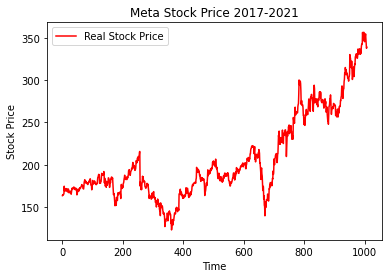

In [131]:
plt.plot(trainingData, color = 'red', label = 'Real Stock Price')
plt.title('Meta Stock Price 2017-2021')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Take in the Daily Opening Values
Our data frame as shown above has many values of statistical interest for stock analysis. However, for the purposes of this exercise, we will be just training and testing our model with the daily open values.

In [132]:
trainingData = df.iloc[:, 1:2].values

trainingData

array([[163.589996],
       [164.800003],
       [164.160004],
       ...,
       [344.910004],
       [337.570007],
       [338.799988]])

### Scale the Data
It is imperative that our values are scaled before being fed into our model in order to avoid overfitting. The below performs that.


In [133]:
# Declare scaler structure and perform scaling
sc = MinMaxScaler(feature_range = (0, 1))
trainingDataScaled = sc.fit_transform(trainingData)

# Break if it hasn't been scaled properly
for i in trainingDataScaled:
  assert(0 <= i and i <= 1.1)

trainingDataScaled

array([[0.173479  ],
       [0.17866326],
       [0.17592119],
       ...,
       [0.95034278],
       [0.91889463],
       [0.92416447]])

### Create Time Step Training Data

In [134]:
# Initialize empty arrays
X_train = []
y_train = []

# Set values for time steps into the training set and labels
for i in range(numTimeSteps, len(trainingDataScaled)):
    X_train.append(trainingDataScaled[i-numTimeSteps: i, 0])
    y_train.append(trainingDataScaled[i, 0])

# Convert lists into numpy arrays to add dimensionality
X_train, y_train = np.array(X_train), np.array(y_train)

# Show current dimensionality
X_train.shape

(948, 60)

### Add dimension to training data

In [135]:
# Reshape the array with the new dimension
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Break flow of execution if it's not a 3d tensor
assert(len(X_train.shape) == 3)

# Show our shape
X_train.shape

(948, 60, 1)

## Creating the Model

### Creating the Layers

In [136]:
if loadingModel == False:
  # Initialize the Regresor
  RNN = Sequential()

  # Adding the first LSTM layer with some "Dropout" regularization
  RNN.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  RNN.add(Dropout(dropoutValue))

  # Adding the 2nd LSTM layer with some "Dropout" regularization
  RNN.add(LSTM(units = 50, return_sequences = True))
  RNN.add(Dropout(dropoutValue))

  # Adding the 3rd LSTM layer with some "Dropout" regularization
  RNN.add(LSTM(units = 50, return_sequences = True))
  RNN.add(Dropout(dropoutValue))

  # Adding the 4th LSTM layer with some "Dropout" regularization
  RNN.add(LSTM(units = 50))
  RNN.add(Dropout(dropoutValue))

  # Add output layer
  RNN.add(Dense(units = 1))

# Else we load our model from a drive file
else:
  RNN = load_model(modelFileName)


# Break the flow of execution of the model somehow isn't loaded
assert(RNN)

### Train the RNN

In [137]:
# Training the LSTM model
if loadingModel == False:
  # Compiling the LSTM model
  RNN.compile(optimizer = 'adam', loss = 'mean_squared_error')
  # Fit Model
  RNN.fit(X_train, y_train, epochs = numEpochs, batch_size = 32)

Epoch 1/200
30/30 [==============================] - 12s 132ms/step - loss: 0.0342
Epoch 2/200
30/30 [==============================] - 4s 128ms/step - loss: 0.0043
Epoch 3/200
30/30 [==============================] - 4s 128ms/step - loss: 0.0042
Epoch 4/200
30/30 [==============================] - 4s 132ms/step - loss: 0.0044
Epoch 5/200
30/30 [==============================] - 4s 126ms/step - loss: 0.0037
Epoch 6/200
30/30 [==============================] - 4s 126ms/step - loss: 0.0040
Epoch 7/200
30/30 [==============================] - 4s 126ms/step - loss: 0.0036
Epoch 8/200
30/30 [==============================] - 4s 123ms/step - loss: 0.0031
Epoch 9/200
30/30 [==============================] - 4s 128ms/step - loss: 0.0033
Epoch 10/200
30/30 [==============================] - 4s 126ms/step - loss: 0.0031
Epoch 11/200
30/30 [==============================] - 4s 124ms/step - loss: 0.0030
Epoch 12/200
30/30 [==============================] - 4s 127ms/step - loss: 0.0031
Epoch 13/200

### Save the RNN

In [138]:
# Create a directory if one doesn't exist
!mkdir -p models

if loadingModel == False:
  # Save the model
  RNN.save('/content/drive/My Drive/Colab Notebooks/Deep_Learning/Module_4/' + modelFileName)

## Making Predictions

### Load Testing Data

In [139]:
# Read in the data from our Google Drive file
df_test = pd.read_csv(dataTrainFileName)

# Break if the data seems to be empty
assert(df_test.shape[0] > 0 and df_test.shape[1] > 0)

df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-19,163.589996,165.699997,163.169998,164.139999,164.139999,26273600
1,2017-07-20,164.800003,165.000000,162.809998,164.529999,164.529999,18523100
2,2017-07-21,164.160004,165.050003,163.750000,164.429993,164.429993,14744000
3,2017-07-24,164.639999,166.169998,164.309998,166.000000,166.000000,17367000
4,2017-07-25,165.009995,165.539993,163.860001,165.279999,165.279999,15383200


### Obtaining Opening Columns in Data Frame

In [140]:
# Set the testing data
testingData = df_test.iloc[:, 1:2].values

testingData

array([[163.589996],
       [164.800003],
       [164.160004],
       ...,
       [344.910004],
       [337.570007],
       [338.799988]])

### Preparing Test Data

In [141]:
# Combine and transform the datasets
dataset_combined = pd.concat((df['Open'], df_test['Open']), axis = 0)
inputs = dataset_combined[len(dataset_combined) - len(testingData) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

### Creating Time Step Testing Data

In [142]:
# Initialize testing data with timestamps
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])

### Add Dimension to Training Data

In [143]:
# Convert time-windows to numpy array and adddimension
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Make Prediction

In [144]:
predicted_stock_price = RNN.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Plotting Predictions

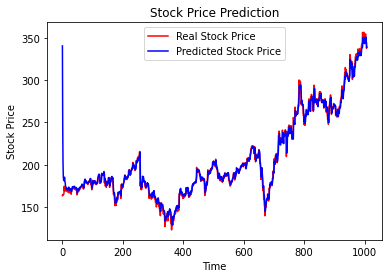

In [145]:
plt.plot(testingData, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()